In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
data = pd.read_csv('ml_GME.csv')
data = data.sort_values('date')
data.tail()

,date,close,volume,mentions,sentiment,ticker_sent,pct_ch,up_neu_dn
57,2021-06-22,220.53,7381118,147.0,381.4539,32.5225,0.099955,1
58,2021-06-23,218.91,3342402,158.0,384.2456,23.1220,-0.007346,0
59,2021-06-24,212.35,3714752,135.0,413.4690,14.5860,-0.029967,-1
60,2021-06-25,209.25,5868539,145.0,440.5769,33.8516,-0.014599,-1
61,2021-06-28,213.10,4594809,119.0,385.8896,37.4977,0.018399,1


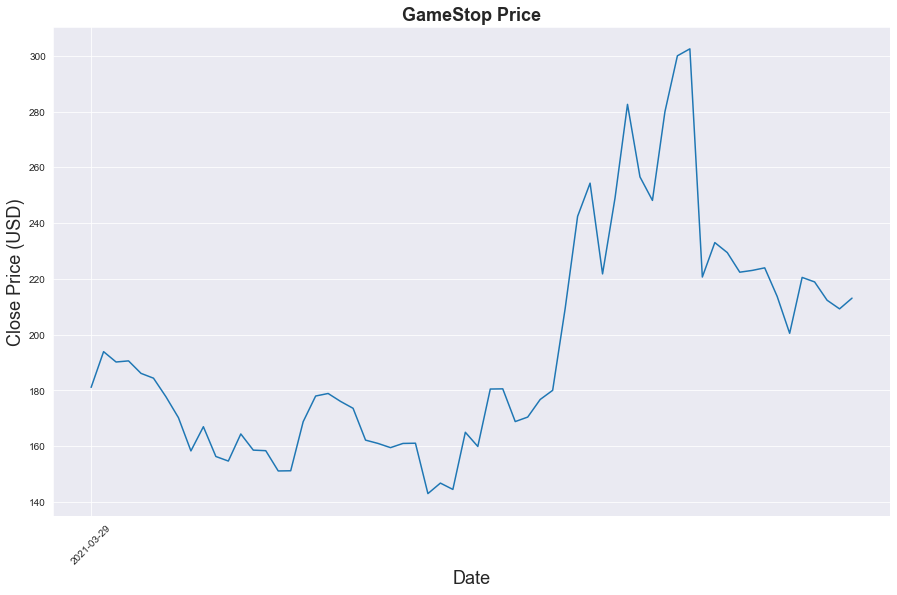

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['close']])
plt.xticks(range(0,data.shape[0],500),data['date'].loc[::500],rotation=45)
plt.title("GameStop Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [9]:
price = data[['close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


In [10]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))

<ipython-input-10-95d283afa8b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))


In [11]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [12]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (34, 19, 2)
y_train.shape =  (34, 2)
x_test.shape =  (8, 19, 2)
y_test.shape =  (8, 2)


In [13]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [24]:
input_dim = 2
hidden_dim = 32
num_layers = 2
output_dim = 2
num_epochs = 100

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  21669.310546875
Epoch  1 MSE:  21604.69921875
Epoch  2 MSE:  21527.373046875
Epoch  3 MSE:  21442.5390625
Epoch  4 MSE:  21353.263671875
Epoch  5 MSE:  21265.873046875
Epoch  6 MSE:  21180.548828125
Epoch  7 MSE:  21094.39453125
Epoch  8 MSE:  21005.15234375
Epoch  9 MSE:  20914.48046875
Epoch  10 MSE:  20825.94921875
Epoch  11 MSE:  20741.689453125
Epoch  12 MSE:  20661.0546875
Epoch  13 MSE:  20582.693359375
Epoch  14 MSE:  20505.521484375
Epoch  15 MSE:  20428.64453125
Epoch  16 MSE:  20351.89453125
Epoch  17 MSE:  20276.271484375
Epoch  18 MSE:  20202.96875
Epoch  19 MSE:  20131.044921875
Epoch  20 MSE:  20060.1640625
Epoch  21 MSE:  19990.216796875
Epoch  22 MSE:  19920.908203125
Epoch  23 MSE:  19851.9296875
Epoch  24 MSE:  19783.158203125
Epoch  25 MSE:  19714.546875
Epoch  26 MSE:  19646.08984375
Epoch  27 MSE:  19577.779296875
Epoch  28 MSE:  19509.615234375
Epoch  29 MSE:  19441.61328125
Epoch  30 MSE:  19373.806640625
Epoch  31 MSE:  19306.193359375
Epoch  32 

In [28]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

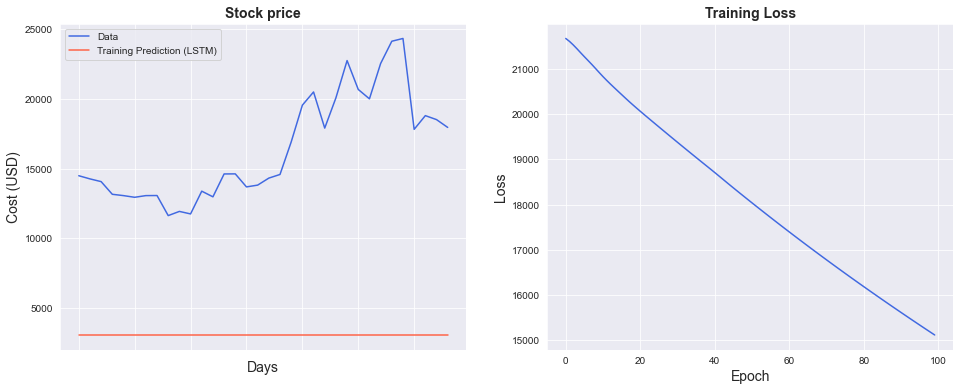

In [29]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)